In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

run_id = "Latency-20250330174023"

with open(f'../outputs/{run_id}/profile.json', 'r') as f: stats = json.load(f)
with open(f'../outputs/{run_id}/decoder_stats.json', 'r') as f: online_stats = json.load(f)[0]
latency_dec_loc = np.array([stat["latency_dec_loc"] for stat in stats[:-1]]).T
latency_dec_rem = np.array([stat["latency_dec_rem"] for stat in stats[:-1]]).T
start_step = stats[-1]['start_step'][0]

In [3]:

def denoise(raw_data, window_size=4, threshold=1.0):
    data = []
    for i in range(0, raw_data.shape[0], window_size):
        segment = raw_data[i: i +  window_size]
        mean, std = np.mean(segment), np.std(segment)
        for j, values in enumerate(segment):
            for value in values:
                if abs(value - mean) < std * threshold:
                    data.append([start_step + i + j, value])
    data = np.array(data).T
    return data

def fit_linear_kb(data):
    xs = np.stack([data[0], np.ones_like(data[0])], axis=1)
    k, b = np.linalg.inv(xs.T @ xs) @ xs.T @ np.array(data[1])
    return k, b

def fit_linear_k(data):
    k = (data[0] @ data[1]) / (data[0] @ data[0])
    return k

/data/tmp/ipykernel_95128/2111901812.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


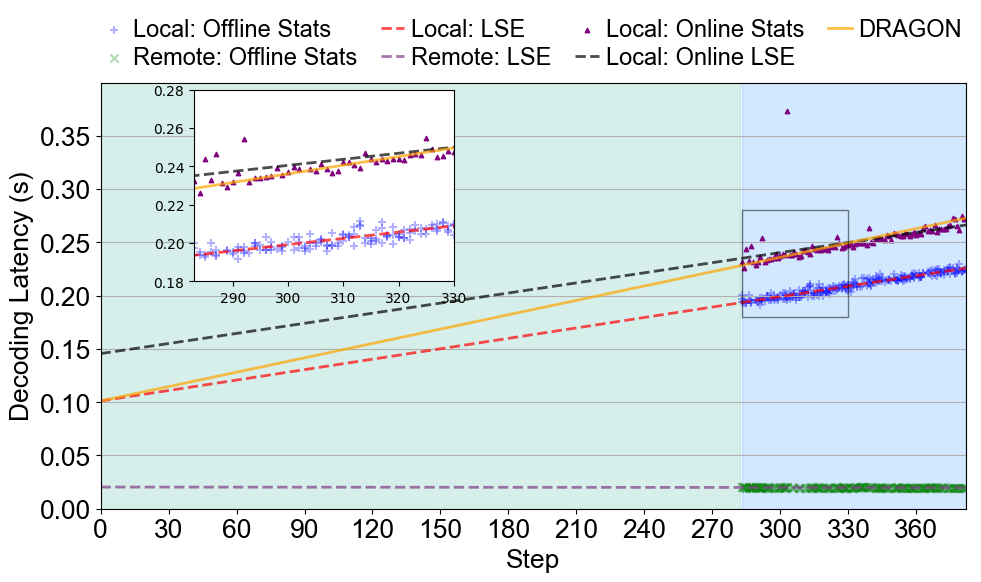

In [82]:
import plt_utils


latency_dec_loc_data = denoise(latency_dec_loc, threshold=0.9, window_size=10)
latency_dec_rem_data = denoise(latency_dec_rem, threshold=0.9, window_size=10)

k_loc, b_loc = fit_linear_kb(latency_dec_loc_data)
k_rem, b_rem = fit_linear_kb(latency_dec_rem_data)

x_axis = np.arange(start_step + len(stats[0]['latency_dec_loc']))
font = plt_utils.Font("arial", size=19)
font_legend = plt_utils.Font("arial", size=17)
plt.figure(figsize=(10, 6), dpi=100)
plt.fill_between(x_axis[:start_step], plt.ylim()[0], plt.ylim()[1], color='#33b29e', alpha=0.2, zorder=1)
plt.fill_between(x_axis[start_step:], plt.ylim()[0], plt.ylim()[1], color='#1e90ff', alpha=0.2, zorder=1)
plt.scatter(latency_dec_loc_data[0], latency_dec_loc_data[1], color='b', label='Local: Offline Stats', marker='+', alpha=0.3)
plt.scatter(latency_dec_rem_data[0], latency_dec_rem_data[1], color='g', label='Remote: Offline Stats', marker='x', alpha=0.3)
plt.plot(x_axis, k_loc * x_axis + b_loc, label='Local: LSE', color='r', linestyle='--', lw=2, alpha=0.7)
plt.plot(x_axis, k_rem * x_axis + b_rem, label='Remote: LSE', color='#813c85', linestyle='--', lw=2, alpha=0.7)
plt.scatter(
    np.array(online_stats['steps']) + start_step, online_stats['latency_dec_loc'], 
    color='purple', label='Local: Online Stats', marker='^', s=10)
k_new, b_new = fit_linear_kb((np.array(online_stats['steps']) + start_step + 1, online_stats['latency_dec_loc']))
plt.plot(x_axis, k_new * x_axis + b_new, label='Local: Online LSE', color='k', linestyle='--', lw=2, alpha=0.7)

origin_c = (latency_dec_loc_data[1] - b_loc) @ latency_dec_loc_data[0]
origin_d = latency_dec_loc_data[0] @ latency_dec_loc_data[0]
for t, lat_new in zip(online_stats['steps'], online_stats['latency_dec_loc']):
    origin_c = 0.1 * origin_c + 0.9 * (lat_new - b_loc) * (t + start_step)
    origin_d = 0.1 * origin_d + 0.9 * (t + start_step) * (t + start_step)
    new_k = origin_c / origin_d
    if t == online_stats['steps'][-1]:
        plt.plot(x_axis, new_k * x_axis + b_loc, label='DRAGON', color='orange', lw=2, alpha=0.7)

plt.grid(axis='y', linestyle='-')
plt.xticks(x_axis[::30], fontproperties=font)
plt.yticks(np.arange(0, 0.4, 0.05), fontproperties=font)
plt.xlim(0, np.max(x_axis))
plt.ylim(0, 0.4)
plt.xlabel('Step', fontproperties=font)
plt.ylabel('Decoding Latency (s)', fontproperties=font)
plt.legend(
    prop=font_legend, loc='upper right',
    bbox_to_anchor=(1.02, 1.2),
    ncol=4, labelspacing=0.2, columnspacing=1, 
    frameon=False, handlelength=1, handletextpad=0.3)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = plt.gca()
axins = inset_axes(ax, width="30%", height="45%", loc='upper left', bbox_to_anchor=(0.1, 0., 1, 1), bbox_transform=ax.transAxes)
x1, x2, y1, y2 = start_step, 330, 0.18, 0.28
axins.scatter(latency_dec_loc_data[0], latency_dec_loc_data[1], color='b', label='Local: Offline Stats', marker='+', alpha=0.3)
axins.scatter(latency_dec_rem_data[0], latency_dec_rem_data[1], color='g', label='Remote: Offline Stats', marker='x', alpha=0.3)
axins.plot(x_axis, k_loc * x_axis + b_loc, label='Local: LSE', color='r', linestyle='--', lw=2, alpha=0.7)
axins.plot(x_axis, k_rem * x_axis + b_rem, label='Remote: LSE', color='#813c85', linestyle='--', lw=2, alpha=0.7)
axins.scatter(
    np.array(online_stats['steps']) + start_step, online_stats['latency_dec_loc'], 
    color='purple', label='Local: Online Stats', marker='^', s=10)
k_new, b_new = fit_linear_kb((np.array(online_stats['steps']) + start_step + 1, online_stats['latency_dec_loc']))
axins.plot(x_axis, k_new * x_axis + b_new, label='Local: Online LSE', color='k', linestyle='--', lw=2, alpha=0.7)

origin_c = (latency_dec_loc_data[1] - b_loc) @ latency_dec_loc_data[0]
origin_d = latency_dec_loc_data[0] @ latency_dec_loc_data[0]
for t, lat_new in zip(online_stats['steps'], online_stats['latency_dec_loc']):
    origin_c = 0.1 * origin_c + 0.9 * (lat_new - b_loc) * (t + start_step)
    origin_d = 0.1 * origin_d + 0.9 * (t + start_step) * (t + start_step)
    new_k = origin_c / origin_d
    if t == online_stats['steps'][-1]:
        axins.plot(x_axis, new_k * x_axis + b_loc, label='DRAGON', color='orange', lw=2, alpha=0.7)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins, edgecolor="black")
plt.tight_layout()
plt.savefig("profiling.png", dpi=200)
plt.show()